In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [2]:
def get_window(raw, annotation):
    window = raw.copy().crop(tmin=annotation['onset'], tmax=annotation['onset']+annotation['duration'])
    
    return window

def get_window_dict(raw, annotations):
    window_dict = {}

    for description in np.unique(annotations.description):

        list_of_windows = []
        for annotation in annotations[annotations.description==description]:
            list_of_windows.append(get_window(raw, annotation))

        window_dict[description] = list_of_windows

    return window_dict

In [82]:
edf_file_path = 'notebooks/S001R03.edf'
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [85]:
raw = get_raw(edf_file_path, filter=True)
annotations = get_annotations(edf_file_path)
annotation_dict = get_window_dict(raw, annotations)

In [86]:
window = annotation_dict['T1'][1]

In [87]:
src = get_src(src_path)
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)
stc = get_stc(window, fwd, cov)

In [106]:
parcellation_name = "HCPMMP1_combined"
labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

In [107]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [136]:
#activity = get_power_per_label(stc, labels)
values = np.sum(stc.data**2, axis=1).reshape(2, 10242) #activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

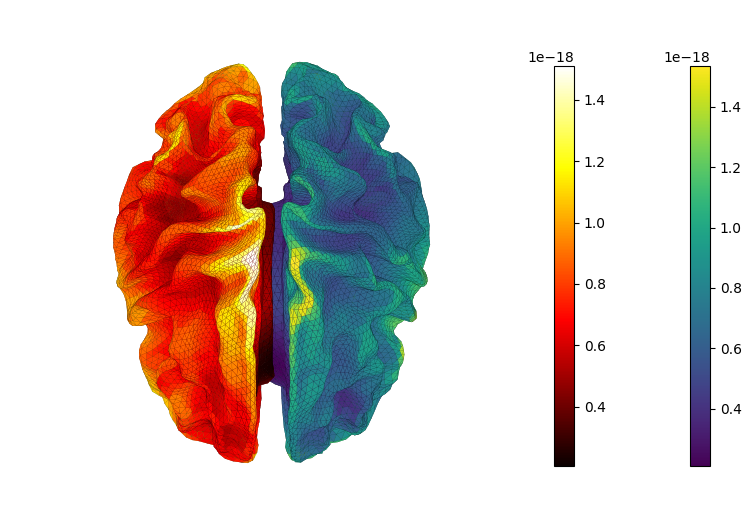

In [138]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="viridis")

lh_mesh.set_array(tris_values[0])
fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

In [120]:
for i in range(len(labels[0])):
    print(i, labels[0][i].name)

0 ???-lh
1 Anterior Cingulate and Medial Prefrontal Cortex-lh
2 Auditory Association Cortex-lh
3 Dorsal Stream Visual Cortex-lh
4 DorsoLateral Prefrontal Cortex-lh
5 Early Auditory Cortex-lh
6 Early Visual Cortex-lh
7 Inferior Frontal Cortex-lh
8 Inferior Parietal Cortex-lh
9 Insular and Frontal Opercular Cortex-lh
10 Lateral Temporal Cortex-lh
11 MT+ Complex and Neighboring Visual Areas-lh
12 Medial Temporal Cortex-lh
13 Orbital and Polar Frontal Cortex-lh
14 Paracentral Lobular and Mid Cingulate Cortex-lh
15 Posterior Cingulate Cortex-lh
16 Posterior Opercular Cortex-lh
17 Premotor Cortex-lh
18 Primary Visual Cortex (V1)-lh
19 Somatosensory and Motor Cortex-lh
20 Superior Parietal Cortex-lh
21 Temporo-Parieto-Occipital Junction-lh
22 Ventral Stream Visual Cortex-lh


In [123]:
np.mean(activity[0])

0.60948329737011

In [124]:
np.mean(activity[1])

0.662785153327346

In [121]:
activity[0][19]

0.6786820980767468

In [122]:
activity[1][19]

0.8185372977069162